###README: Static test over Tibet track 63 part A to demonstrate temporal sampling (n-1 annual; n-1 semi-annual; n-1 90 days)

This is to demonstrate how to use the `s1-enumerator` to get a full time series of GUNWs.

We are going basically take each month in acceptable date range and increment by a month and make sure the temporal window is large enough to ensure connectivity across data gaps.

# Parameters

This is what the operator is going to have to change. Will provide some comments.

In [1]:
# toggle user-controlled parameters here
import datetime
import json

# product cutline
aoi_shapefile = 'TibetA_pathNumber63.geojson'
# load AO geojson and strip variables
with open(aoi_shapefile, 'r') as file:
    data = json.load(file)
    json_keys = data['features'][0]['properties'].keys()
    # assign local variables from dict
    locals().update(data['features'][0]['properties'])

# Override metadata keys
# Warning, toggle with caution
# Only to be used if you are testing and intentionally updating AO geojsons
update_AO = True

### Spatial coverage constraint parameter 'azimuth_mismatch'
# The merged SLC area over the AOI is allowed to be smaller by 'azimuth_mismatch' x swath width (i.e. 250km)
if 'azimuth_mismatch' not in json_keys or update_AO:
    azimuth_mismatch = 50 # adjust as necessary
    data['features'][0]['properties']['azimuth_mismatch'] = azimuth_mismatch

# Specify deployment URL
deploy_url = 'https://hyp3-tibet.asf.alaska.edu' #for Tibet
#deploy_url = 'https://hyp3-isce.asf.alaska.edu' #for access
data['features'][0]['properties']['deploy_url'] = deploy_url

# Number of nearest neighbors
if 'num_neighbors' not in json_keys or update_AO:
    num_neighbors = 0 # adjust as necessary
    data['features'][0]['properties']['num_neighbors'] = num_neighbors

#set temporal parameters
if 'min_days_backward' not in json_keys or update_AO:
    min_days_backward = 0
    data['features'][0]['properties']['min_days_backward'] = min_days_backward
today = datetime.datetime.now()
# Earliest year for reference frames
START_YEAR = 2014
# Latest year for reference frames
END_YEAR = today.year
YEARS_OF_INTEREST = list(range(START_YEAR,END_YEAR+1))
# Adjust depending on seasonality
# For annual IFGs, select a single months of interest and you will get what you want.
if 'month_range_lower' not in json_keys or update_AO:
    month_range_lower = 1 # adjust as necessary
    data['features'][0]['properties']['month_range_lower'] = month_range_lower
if 'month_range_upper' not in json_keys or update_AO:
    month_range_upper = 12 # adjust as necessary
    data['features'][0]['properties']['month_range_upper'] = month_range_upper
MONTHS_OF_INTEREST = list(range(month_range_lower,month_range_upper+1))


############################################################################################################
## OPTIONAL set temporal sampling parameters

# Temporal sampling invervals
if 'min_days_backward_timesubset' not in json_keys or update_AO:
    # Specify as many temporal sampling intervals as desired (e.g. 90 (days), 180 (days) = semiannual, 365 (days) = annual, etc.)
    min_days_backward_timesubset = [365, 180]
    if min_days_backward_timesubset != []:
        data['features'][0]['properties']['min_days_backward_timesubset'] = ','.join(map(str, min_days_backward_timesubset))
if 'min_days_backward_timesubset' in json_keys:
    min_days_backward_timesubset = [int(s) for s in data['features'][0]['properties']['min_days_backward_timesubset'].split(',')]
# apply temporal window to all temporal sampling intervals (hardcoded to 60 days)
temporal_window_days_timesubset = 60
min_days_backward_timesubset = [i - round(temporal_window_days_timesubset/2) for i in min_days_backward_timesubset]
if any(x<1 for x in min_days_backward_timesubset):
    raise Exception("Your specified 'min_days_backward_timesubset' input is too small relative to"
                    "your specified 'temporal_window_days_timesubset' value. Adjust accordingly")

# Nearest neighbor sampling
if 'num_neighbors_timesubset' not in json_keys or update_AO:
    # Specify corresponding nearest neighbor sampling for each temporal sampling interval (by default (n-)1)
    num_neighbors_timesubset = [1, 1]
    if num_neighbors_timesubset != []:
        data['features'][0]['properties']['num_neighbors_timesubset'] = ','.join(map(str, num_neighbors_timesubset))
if 'num_neighbors_timesubset' in json_keys:
    num_neighbors_timesubset = [int(s) for s in data['features'][0]['properties']['num_neighbors_timesubset'].split(',')]

if len (num_neighbors_timesubset) != len(min_days_backward_timesubset):
    raise Exception("Specified number of temporal sampling intervals DO NOT match specified nearest neighbor sampling")
############################################################################################################


# Define job-name
if 'job_name' not in json_keys or update_AO:
    job_name = aoi_shapefile.split('/')[-1].split('.')[0].split('pathNumber')
    job_name = ''.join(job_name)
    job_name = job_name[-20:]
    data['features'][0]['properties']['job_name'] = job_name
# product directory
prod_dir = job_name

# if operator variables do not exist, set and populate geojson with them
with open(aoi_shapefile, 'w') as file:
    json.dump(data, file)

In [2]:
from s1_enumerator import get_aoi_dataframe,  distill_all_pairs, enumerate_ifgs, get_s1_coverage_tiles, enumerate_ifgs_from_stack, get_s1_stack_by_dataframe
import concurrent
from rasterio.crs import CRS
from s1_enumerator import duplicate_gunw_found
from tqdm import tqdm
from shapely.geometry import Point, shape
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from dateutil.relativedelta import relativedelta
import networkx as nx
import boto3
import hyp3_sdk
import copy

In [3]:
def shapefile_area(file_bbox,
        bounds = False):
    """Compute km\u00b2 area of shapefile."""
    # import dependencies
    from pyproj import Proj

    # loop through polygons
    shape_area = 0
    # pass single polygon as list
    if file_bbox.type == 'Polygon': file_bbox = [file_bbox]
    for polyobj in file_bbox:
        #first check if empty
        if polyobj.is_empty:
            shape_area += 0
            continue
        # get coords
        if bounds:
            # Pass coordinates of bounds as opposed to cutline
            # Necessary for estimating DEM/mask footprints
            WSEN = polyobj.bounds
            lon = np.array([WSEN[0],WSEN[0],WSEN[2],WSEN[2],WSEN[0]])
            lat = np.array([WSEN[1],WSEN[3],WSEN[3],WSEN[1],WSEN[1]])
        else:
            lon, lat = polyobj.exterior.coords.xy

        # use equal area projection centered on/bracketing AOI
        pa = Proj("+proj=aea +lat_1={} +lat_2={} +lat_0={} +lon_0={}". \
             format(min(lat), max(lat), (max(lat)+min(lat))/2, \
             (max(lon)+min(lon))/2))
        x, y = pa(lon, lat)
        cop = {"type": "Polygon", "coordinates": [zip(x, y)]}
        shape_area += shape(cop).area/1e6  # area in km^2

    return shape_area

In [4]:
def continuous_time(product_df, iter_id='fileID'):
    """
    Split the products into spatiotemporally continuous groups.
    Split products by individual, continuous interferograms.
    Input must be already sorted by pair and start-time to fit
    the logic scheme below.
    Using their time-tags, this function determines whether or not
    successive products are in the same orbit.
    If in the same orbit, the program determines whether or not they
    overlap in time and are therefore spatially contiguous,
    and rejects/reports cases for which there is no temporal overlap
    and therefore a spatial gap.
    """
    from shapely.ops import unary_union

    # pass scenes that have no gaps
    sorted_products = []
    track_rejected_inds = []
    pair_dict = {}
    product_df_dict = product_df.to_dict('records')
    # Check for (and remove) duplicate products
    # If multiple pairs in list, cycle through
    # and evaluate temporal connectivity.
    for i in enumerate(product_df_dict[:-1]):
        # Parse the first frame's metadata
        scene_start = i[1]['startTime']
        scene_end = i[1]['stopTime']
        first_frame_ind = i[1]['ind_col']
        first_frame = datetime.datetime.strptime( \
                i[1]['fileID'][17:25], "%Y%m%d")
        # Parse the second frame's metadata
        new_scene_start = product_df_dict[i[0]+1]['startTime']
        new_scene_end = product_df_dict[i[0]+1]['stopTime']
        next_frame_ind = product_df_dict[i[0]+1]['ind_col']
        next_frame = datetime.datetime.strptime( \
                product_df_dict[i[0]+1]['fileID'][17:25], "%Y%m%d")

        # Determine if next product in time is in same orbit AND overlaps
        # AND corresponds to same scene
        # If it is within same orbit cycle, try to append scene.
        # This accounts for day change.
        if abs(new_scene_end-scene_end) <= \
                datetime.timedelta(minutes=100) \
                and abs(next_frame-first_frame) <= \
                datetime.timedelta(days=1):
            # Don't export product if it is already tracked
            # as a rejected scene
            if first_frame_ind in track_rejected_inds or \
                    next_frame_ind in track_rejected_inds:
                track_rejected_inds.append(first_frame_ind)
                track_rejected_inds.append(next_frame_ind)

            # Only pass scene if it temporally overlaps with reference scene
            elif ((scene_end <= new_scene_start) and \
                    (new_scene_end <= scene_start)) or \
                    ((scene_end >= new_scene_start) and \
                    (new_scene_end >= scene_start)):
                # Check if dictionary for scene already exists,
                # and if it does then append values
                try:
                    dict_ind = sorted_products.index(next(item for item \
                            in sorted_products if i[1][iter_id] \
                            in item[iter_id]))
                    sorted_products[dict_ind] = {key: np.hstack([value] + \
                         [product_df_dict[i[0]+1][key]]).tolist() \
                         for key, value in sorted_products[dict_ind].items()}
                # Match corresponding to scene NOT found,
                # so initialize dictionary for new scene
                except:
                    sorted_products.extend([dict(zip(i[1].keys(), \
                            [list(a) for a in zip(i[1].values(), \
                            product_df_dict[i[0]+1].values())]))])

            # Else if scene doesn't overlap, this means there is a gap.
            # Reject date from product list,
            # and keep track of all failed dates
            else:
                track_rejected_inds.append(first_frame_ind)
                track_rejected_inds.append(next_frame_ind)
        # Products correspond to different dates,
        # So pass both as separate scenes.
        else:
            # Check if dictionary for corresponding scene already exists.
            if [item for item in sorted_products if i[1][iter_id] in \
                    item[iter_id]]==[] and i[1]['ind_col'] not in \
                    track_rejected_inds:
                sorted_products.extend([dict(zip(i[1].keys(), \
                        [list(a) for a in zip(i[1].values())]))])
            # Initiate new scene
            if [item for item in sorted_products if \
                    product_df_dict[i[0]+1][iter_id] in item[iter_id]]==[] \
                    and next_frame_ind not in track_rejected_inds:
                sorted_products.extend([dict(zip( \
                        product_df_dict[i[0]+1].keys(), \
                        [list(a) for a in \
                        zip(product_df_dict[i[0]+1].values())]))])
            if first_frame_ind in track_rejected_inds:
                track_rejected_inds.append(first_frame_ind)
            if next_frame_ind in track_rejected_inds:
                track_rejected_inds.append(next_frame_ind)

    # Remove duplicate dates
    track_rejected_inds = list(set(track_rejected_inds))
    if len(track_rejected_inds) > 0:
        print("{}/{} scenes rejected as stitched IFGs have gaps".format( \
             len(track_rejected_inds), len(product_df)))
        # Provide report of which files were kept vs. which were not.
        print("Specifically, the following scenes were rejected:")
        for item in product_df_dict:
            if item['ind_col'] in track_rejected_inds:
                print(item['fileID'])
    else:
        print("All {} scenes are spatially continuous.".format( \
             len(sorted_products)))

    # pass scenes that have no gaps
    sorted_products = [item for item in sorted_products \
            if not (any(x in track_rejected_inds for x in item['ind_col']))]

    # Report dictionaries for all valid products
    if sorted_products == []: #Check if pairs were successfully selected
        raise Exception('No scenes meet spatial criteria'
                        'due to gaps and/or invalid input.'
                        'Nothing to export.')

    # Combine polygons
    for i in enumerate(sorted_products):
        sorted_products[i[0]]['geometry'] = unary_union(i[1]['geometry'])

    # combine and record scenes with gaps
    track_kept_inds = pd.DataFrame(sorted_products)['ind_col'].to_list()
    track_kept_inds = [item for sublist in track_kept_inds for item in sublist]
    temp_gap_scenes_dict = [item for item in product_df_dict \
            if not item['ind_col'] in track_kept_inds]
    gap_scenes_dict = []
    for i in enumerate(temp_gap_scenes_dict[:-1]):
        # Parse the first frame's metadata
        first_frame_ind = i[1]['ind_col']
        first_frame = datetime.datetime.strptime( \
                i[1]['fileID'][17:25], "%Y%m%d")
        # Parse the second frame's metadata
        next_frame_ind = temp_gap_scenes_dict[i[0]+1]['ind_col']
        next_frame = datetime.datetime.strptime( \
                temp_gap_scenes_dict[i[0]+1]['fileID'][17:25], "%Y%m%d")
        # Determine if next product in time is in same orbit
        # If it is within same orbit cycle, try to append scene.
        # This accounts for day change.
        if abs(next_frame-first_frame) <= \
            datetime.timedelta(days=1):
            # Check if dictionary for scene already exists,
            # and if it does then append values
            try:
                dict_ind = gap_scenes_dict.index(next(item for item \
                        in gap_scenes_dict if i[1][iter_id] \
                        in item[iter_id]))
                gap_scenes_dict[dict_ind] = {key: np.hstack([value] + \
                        [temp_gap_scenes_dict[i[0]+1][key]]).tolist() \
                        for key, value in gap_scenes_dict[dict_ind].items()}
            # Match corresponding to scene NOT found,
            # so initialize dictionary for new scene
            except:
                gap_scenes_dict.extend([dict(zip(i[1].keys(), \
                        [list(a) for a in zip(i[1].values(), \
                        temp_gap_scenes_dict[i[0]+1].values())]))])
        # Products correspond to different dates,
        # So pass both as separate scenes.
        else:
            # Check if dictionary for corresponding scene already exists.
            if [item for item in gap_scenes_dict if i[1][iter_id] in \
                    item[iter_id]]==[]:
                gap_scenes_dict.extend([dict(zip(i[1].keys(), \
                        [list(a) for a in zip(i[1].values())]))])
            # Initiate new scene
            if [item for item in gap_scenes_dict if \
                    temp_gap_scenes_dict[i[0]+1][iter_id] in item[iter_id]]==[]:
                gap_scenes_dict.extend([dict(zip( \
                        temp_gap_scenes_dict[i[0]+1].keys(), \
                        [list(a) for a in \
                        zip(temp_gap_scenes_dict[i[0]+1].values())]))])

    # there may be some extra missed pairs with gaps
    if gap_scenes_dict != []:
        extra_track_rejected_inds = pd.DataFrame(gap_scenes_dict)['ind_col'].to_list()
        extra_track_rejected_inds = [item for sublist in extra_track_rejected_inds for item in sublist]
        track_rejected_inds.extend(extra_track_rejected_inds)

    return sorted_products, track_rejected_inds, gap_scenes_dict

In [5]:
def minimum_overlap_query(tiles,
        aoi,
        azimuth_mismatch=0.01,
        iter_id='fileID'):
    """
    Master function managing checks for SAR scene spatiotemporal contiguity
    and filtering out scenes based off of user-defined spatial coverage threshold
    """
    # initiate dataframe
    tiles = tiles.sort_values(['startTime'])
    updated_tiles = tiles.copy()

    # Drop scenes that don't intersect with AOI at all
    orig_len = updated_tiles.shape[0]
    for index, row in tiles.iterrows():
        intersection_area = aoi.intersection(row['geometry'])
        overlap_area = shapefile_area(intersection_area)
        aoi_area = shapefile_area(aoi)
        percentage_coverage = (overlap_area/aoi_area)*100
        if percentage_coverage == 0:
            drop_ind = updated_tiles[updated_tiles['fileID'] == row['fileID']].index
            updated_tiles = updated_tiles.drop(index=drop_ind)
    updated_tiles = updated_tiles.reset_index(drop=True)
    print("{}/{} scenes rejected for not intersecting with the AOI".format( \
          orig_len-updated_tiles.shape[0], orig_len))

    # group IFGs spatiotemporally
    updated_tiles['ind_col'] = range(0, len(updated_tiles))
    updated_tiles_dict, dropped_indices, gap_scenes_dict = continuous_time(updated_tiles, iter_id)
    for i in dropped_indices:
        drop_ind = updated_tiles.index[updated_tiles['ind_col'] == i]
        updated_tiles.drop(drop_ind, inplace=True)
    updated_tiles = updated_tiles.reset_index(drop=True)
    
    # Kick out scenes that do not meet user-defined spatial threshold
    aoi_area = shapefile_area(aoi)
    orig_len = updated_tiles.shape[0]
    track_rejected_inds = []
    minimum_overlap_threshold = aoi_area - (250 * azimuth_mismatch)
    print("")
    print("AOI coverage: {}".format(aoi_area))
    print("Allowable area of miscoverage: {}".format(250 * azimuth_mismatch))
    print("minimum_overlap_threshold: {}".format(minimum_overlap_threshold))
    print("")
    if minimum_overlap_threshold < 0:
        raise Exception('WARNING: user-defined mismatch of {}km\u00b2 too large relative to specified AOI'.format(azimuth_mismatch))
    for i in enumerate(updated_tiles_dict):
        intersection_area = aoi.intersection(i[1]['geometry'])
        overlap_area = shapefile_area(intersection_area)
        # Kick out scenes below specified overlap threshold
        if minimum_overlap_threshold > overlap_area:
            for iter_ind in enumerate(i[1]['ind_col']):
                track_rejected_inds.append(iter_ind[1])
                print("Rejected scene {} has only {}km\u00b2 overlap with AOI".format( \
                    i[1]['fileID'][iter_ind[0]], int(overlap_area)))
                drop_ind = updated_tiles[updated_tiles['ind_col'] == iter_ind[1]].index
                updated_tiles = updated_tiles.drop(index=drop_ind)
    updated_tiles = updated_tiles.reset_index(drop=True)
    print("{}/{} scenes rejected for not meeting defined spatial criteria".format( \
          orig_len-updated_tiles.shape[0], orig_len))

    # record rejected scenes separately
    rejected_scenes_dict = [item for item in updated_tiles_dict \
            if (any(x in track_rejected_inds for x in item['ind_col']))]
    # pass scenes that are not tracked as rejected
    updated_tiles_dict = [item for item in updated_tiles_dict \
            if not (any(x in track_rejected_inds for x in item['ind_col']))]

    return updated_tiles, pd.DataFrame(updated_tiles_dict), pd.DataFrame(gap_scenes_dict), pd.DataFrame(rejected_scenes_dict)

In [6]:
def pair_spatial_check(tiles,
        aoi,
        azimuth_mismatch=0.01,
        iter_id='fileID'):
    """
    Santity check function to confirm selected pairs meet user-defined spatial coverage threshold
    """
    tiles['ind_col'] = range(0, len(tiles))
    tiles = tiles.drop(columns=['reference', 'secondary'])
    tiles_dict, dropped_pairs, gap_scenes_dict = continuous_time(tiles, iter_id='ind_col')

    # Kick out scenes that do not meet user-defined spatial threshold
    aoi_area = shapefile_area(aoi)
    orig_len = tiles.shape[0]
    track_rejected_inds = []
    minimum_overlap_threshold = aoi_area - (250 * azimuth_mismatch)
    if minimum_overlap_threshold < 0:
        raise Exception('WARNING: user-defined mismatch of {}km\u00b2 too large relative to specified AOI'.format(azimuth_mismatch))
    for i in enumerate(tiles_dict):
        intersection_area = aoi.intersection(i[1]['geometry'])
        overlap_area = shapefile_area(intersection_area)
        # Kick out scenes below specified overlap threshold
        if minimum_overlap_threshold > overlap_area:
            for iter_ind in enumerate(i[1]['ind_col']):
                track_rejected_inds.append(iter_ind[1])
                print("Rejected pair {} has only {}km\u00b2 overlap with AOI {}ID {}Ind".format( \
                      i[1]['reference_date'][iter_ind[0]].replace('-', '') + '_' + \
                      i[1]['secondary_date'][iter_ind[0]].replace('-', ''), \
                      overlap_area, iter_ind[1], i[0]))
                drop_ind = tiles[tiles['ind_col'] == iter_ind[1]].index
                tiles = tiles.drop(index=drop_ind)
    tiles = tiles.reset_index(drop=True)
    print("{}/{} scenes rejected for not meeting defined spatial criteria".format( \
          orig_len-tiles.shape[0], orig_len))

    # record rejected scenes separately
    rejected_scenes_dict = [item for item in tiles_dict \
            if (any(x in track_rejected_inds for x in item['ind_col']))]
    # pass scenes that are not tracked as rejected
    tiles_dict = [item for item in tiles_dict \
            if not (any(x in track_rejected_inds for x in item['ind_col']))]

    return pd.DataFrame(tiles_dict), pd.DataFrame(gap_scenes_dict), pd.DataFrame(rejected_scenes_dict)

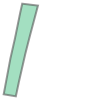

In [7]:
df_aoi = gpd.read_file(aoi_shapefile)
aoi = df_aoi.geometry.unary_union
aoi

Currently, there is a lot of data in each of the rows above. We really only need the AOI `geometry` and the `path_number`.

In [8]:
path_numbers = df_aoi.path_number.unique().tolist()

# Generate a stack

Using all the tiles that are needed to cover the AOI we make a geometric query based on the frame. We now include only the path we are interested in.

In [9]:
path_dict = {}
path_dict['pathNumber'] = str(path_numbers[0])
aoi_geometry = pd.DataFrame([path_dict])
aoi_geometry = gpd.GeoDataFrame(aoi_geometry, geometry=[shape(aoi)], crs=CRS.from_epsg(4326))
aoi_geometry['pathNumber'] = aoi_geometry['pathNumber'].astype(int)

In [10]:
df_stack = get_s1_stack_by_dataframe(aoi_geometry,
                                     path_numbers=path_numbers)

In [11]:
f'We have {df_stack.shape[0]} frames in our stack'

'We have 1851 frames in our stack'

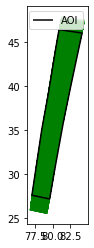

In [12]:
fig, ax = plt.subplots()

df_stack.plot(ax=ax, alpha=.5, color='green', label='Frames interesecting tile')
df_aoi.exterior.plot(color='black', ax=ax, label='AOI')
plt.legend()

Note, we now see the frames cover the entire AOI as we expect.

First remove all scenes that do not produce spatiotemporally contiguous pairs and not meet specified intersection threshold

In [13]:
df_stack, df_stack_dict, gap_scenes_dict, rejected_scenes_dict = minimum_overlap_query(df_stack, aoi, azimuth_mismatch=azimuth_mismatch)

0/1851 scenes rejected for not intersecting with the AOI
117/1851 scenes rejected as stitched IFGs have gaps
Specifically, the following scenes were rejected:
S1A_IW_SLC__1SSV_20141022T003907_20141022T003922_002935_003547_7B7A-SLC
S1A_IW_SLC__1SSV_20141022T003930_20141022T004006_002935_003548_DA4A-SLC
S1A_IW_SLC__1SSV_20141022T004205_20141022T004235_002935_003549_7C16-SLC
S1A_IW_SLC__1SSV_20141022T004233_20141022T004300_002935_003549_0126-SLC
S1A_IW_SLC__1SSV_20141022T004258_20141022T004325_002935_003549_5A4B-SLC
S1A_IW_SLC__1SSV_20141022T004323_20141022T004350_002935_003549_4F13-SLC
S1A_IW_SLC__1SSV_20141022T004348_20141022T004409_002935_003549_E51C-SLC
S1A_IW_SLC__1SSV_20141115T003906_20141115T003921_003285_003CDB_7278-SLC
S1A_IW_SLC__1SSV_20141115T003930_20141115T004005_003285_003CDC_25B9-SLC
S1A_IW_SLC__1SSV_20141115T004204_20141115T004234_003285_003CDD_A5FD-SLC
S1A_IW_SLC__1SSV_20141115T004232_20141115T004300_003285_003CDD_8F3A-SLC
S1A_IW_SLC__1SSV_20141115T004258_20141115T004325_

In [14]:
f'We have {df_stack.shape[0]} frames in our stack'

'We have 988 frames in our stack'

Plot acquisitions that aren't continuous (i.e. have gaps)

/var/folders/13/168512yn66d8nmvt7g6jsybh0000gq/T/ipykernel_60544/138309109.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


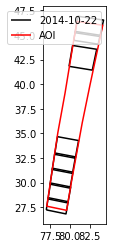

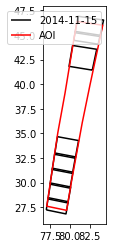

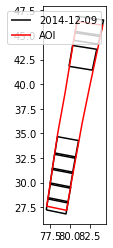

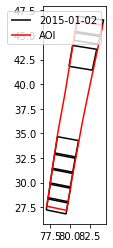

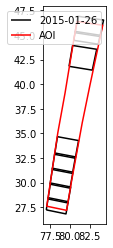

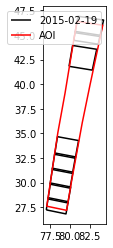

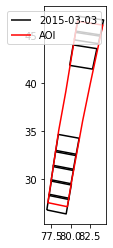

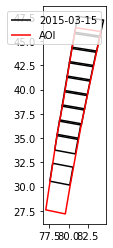

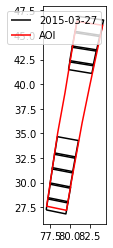

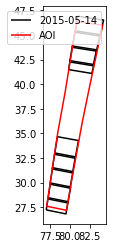

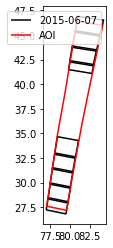

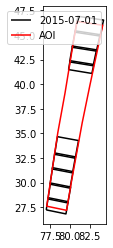

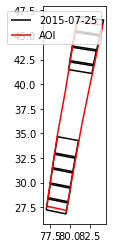

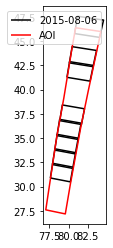

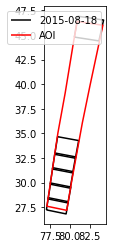

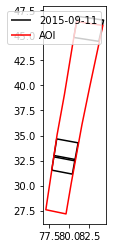

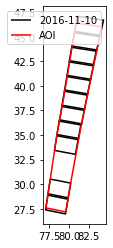

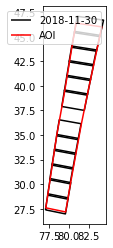

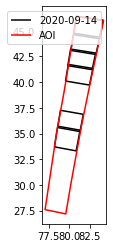

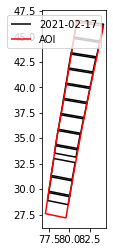

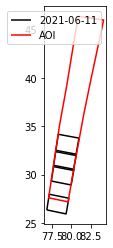

In [15]:
if not gap_scenes_dict.empty:
    gap_scenes_dict =  gap_scenes_dict.sort_values(by=['start_date'])
    for index, row in gap_scenes_dict.iterrows():
        fig, ax = plt.subplots()
        p = gpd.GeoSeries(row['geometry'])
        p.exterior.plot(color='black', ax=ax, label=row['start_date_str'][0])
        df_aoi.exterior.plot(color='red', ax=ax, label='AOI')
        plt.legend()
        plt.show

Plot all mosaicked acquisitions that were rejected for not meeting user-specified spatial constraints

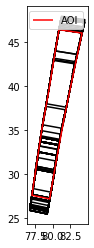

In [16]:
if not rejected_scenes_dict.empty:
    rejected_scenes_dict =  rejected_scenes_dict.sort_values(by=['start_date'])
    fig, ax = plt.subplots()
    for index, row in rejected_scenes_dict.iterrows():
        p = gpd.GeoSeries(row['geometry'])
        p.exterior.plot(color='black', ax=ax)
    df_aoi.exterior.plot(color='red', ax=ax, label='AOI')
    plt.legend()

Plot each individual mosaicked acquisitions that were rejected for not meeting user-specified spatial constraints

/var/folders/13/168512yn66d8nmvt7g6jsybh0000gq/T/ipykernel_60544/3667974998.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


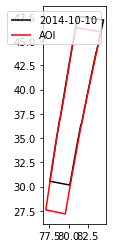

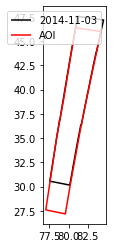

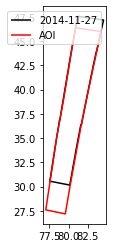

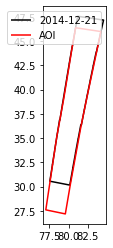

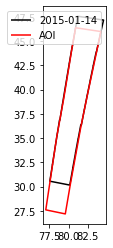

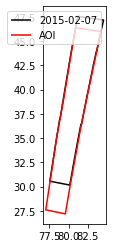

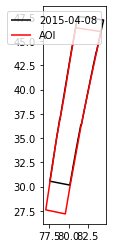

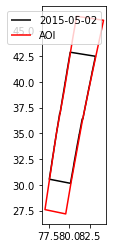

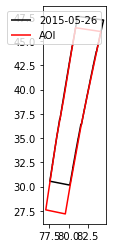

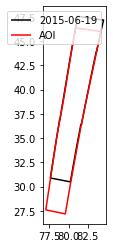

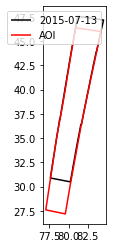

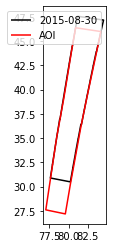

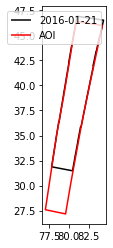

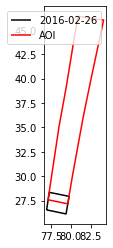

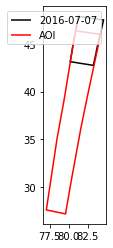

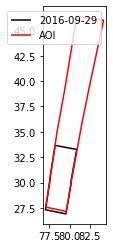

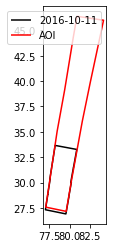

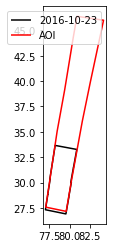

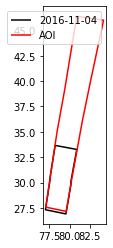

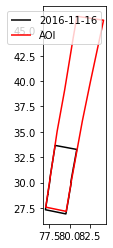

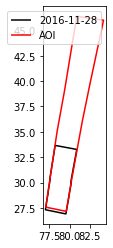

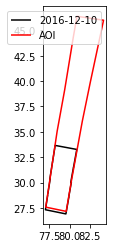

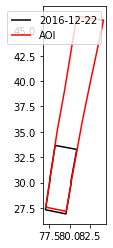

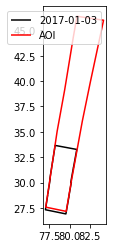

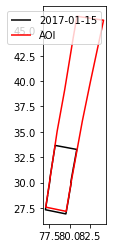

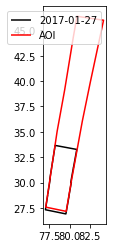

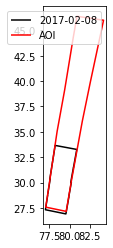

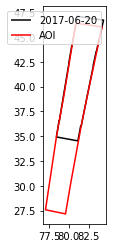

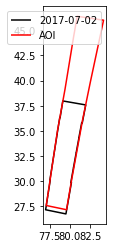

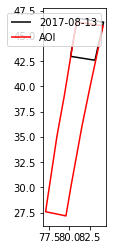

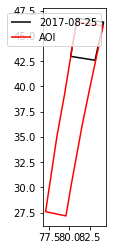

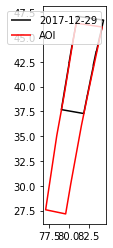

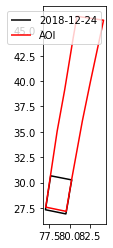

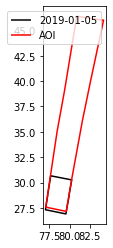

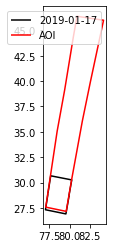

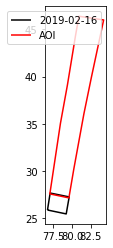

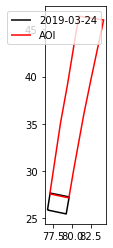

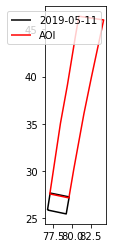

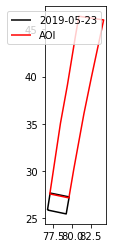

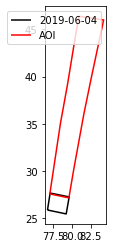

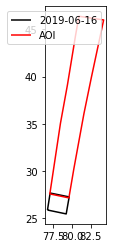

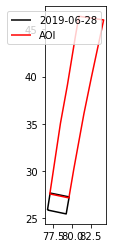

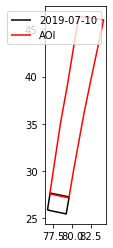

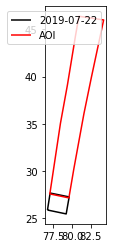

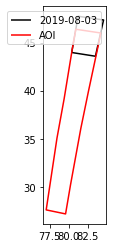

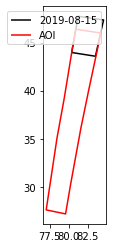

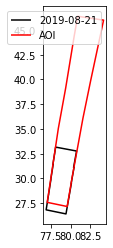

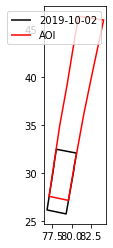

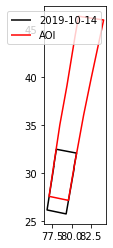

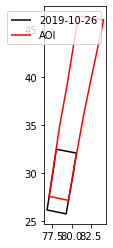

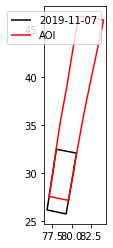

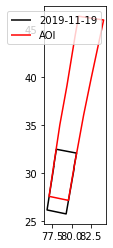

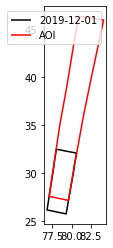

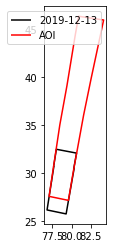

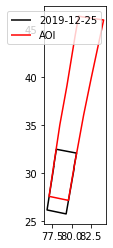

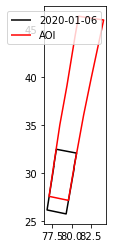

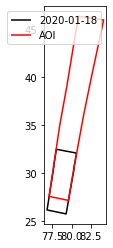

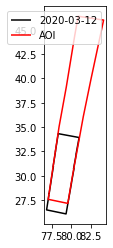

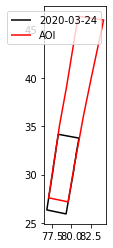

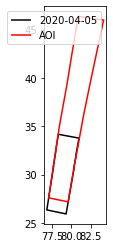

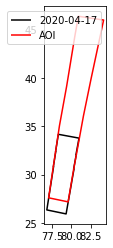

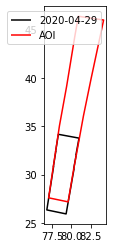

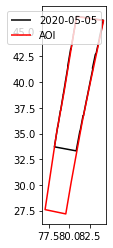

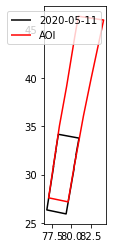

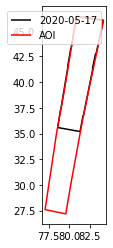

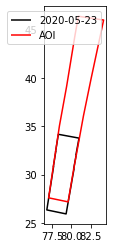

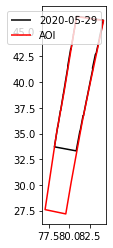

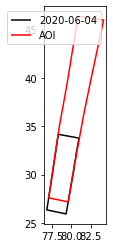

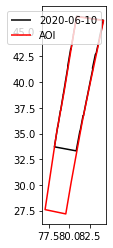

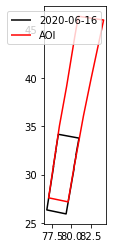

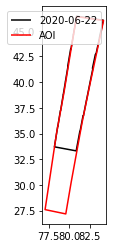

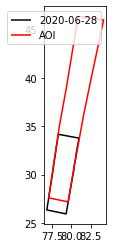

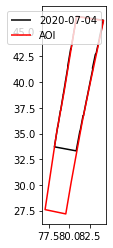

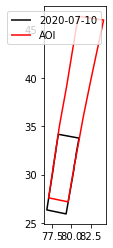

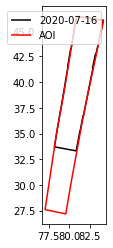

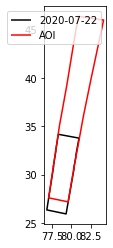

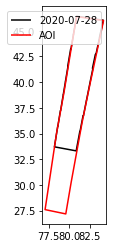

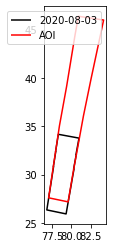

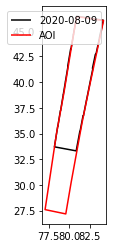

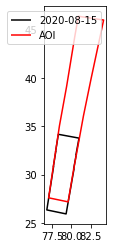

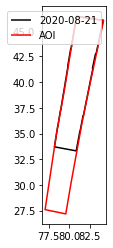

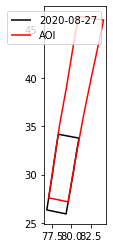

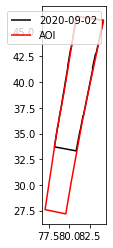

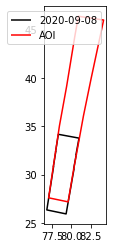

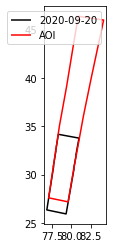

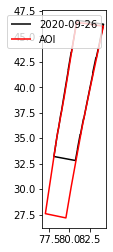

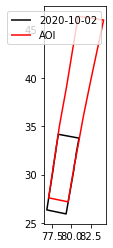

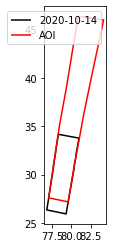

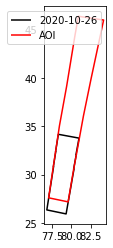

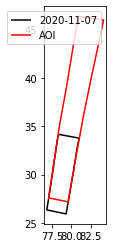

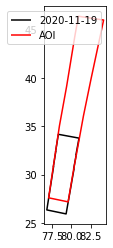

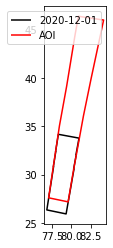

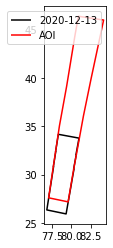

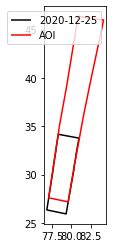

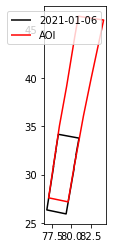

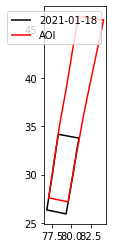

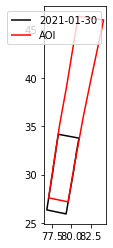

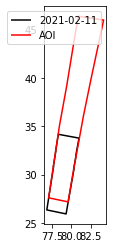

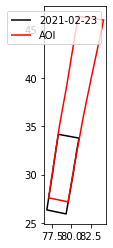

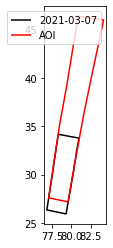

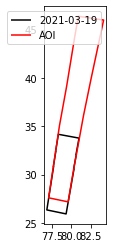

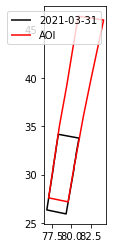

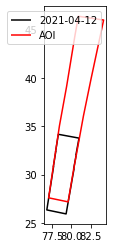

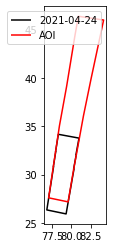

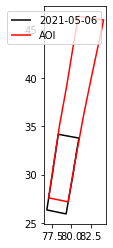

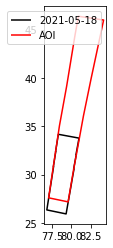

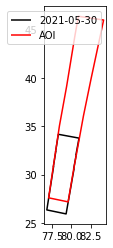

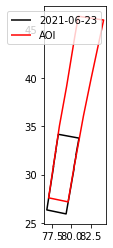

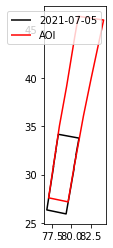

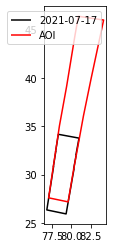

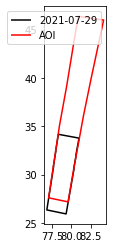

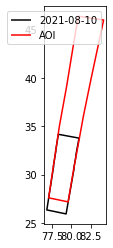

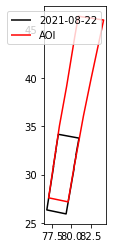

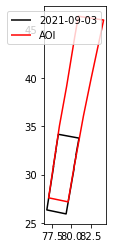

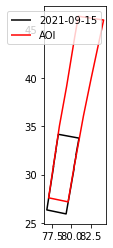

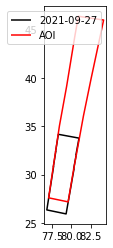

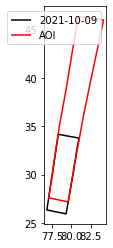

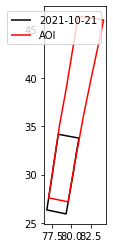

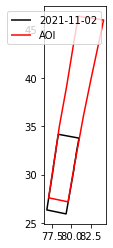

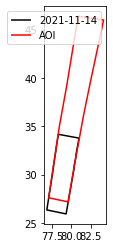

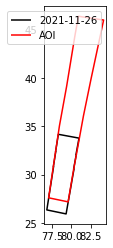

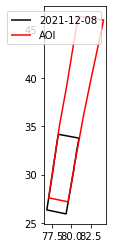

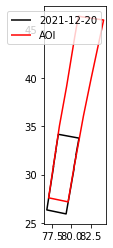

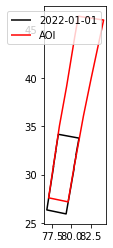

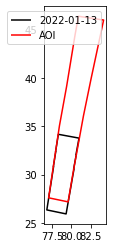

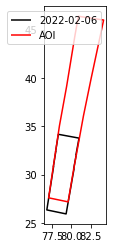

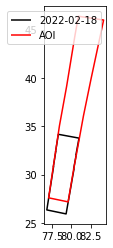

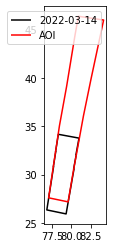

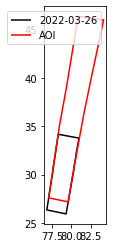

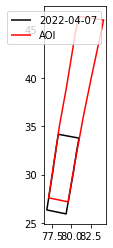

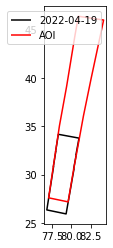

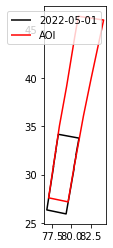

In [17]:
if not rejected_scenes_dict.empty:
    for index, row in rejected_scenes_dict.iterrows():
        fig, ax = plt.subplots()
        p = gpd.GeoSeries(row['geometry'])
        p.exterior.plot(color='black', ax=ax, label=row['start_date_str'][0])
        df_aoi.exterior.plot(color='red', ax=ax, label='AOI')
        plt.legend()
        plt.show

Plot all mosaicked acquisitions that meet user-defined spatial coverage

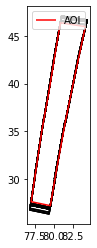

In [18]:
fig, ax = plt.subplots()

for index, row in df_stack_dict.iterrows():
    p = gpd.GeoSeries(row['geometry'])
    p.exterior.plot(color='black', ax=ax)
df_aoi.exterior.plot(color='red', ax=ax, label='AOI')
plt.legend()

Next, we filter the stack by month to ensure we only have SLCs we need.

In [19]:
df_stack_month = df_stack[df_stack.start_date.dt.month.isin(MONTHS_OF_INTEREST)]
df_stack_month = df_stack_month[df_stack_month.start_date.dt.year.isin(YEARS_OF_INTEREST)]

We will create a list of ```min_reference_dates``` in descending order starting with the most recent date from the SLC stack ```df_stack_month``` as the start date.

In [20]:
min_reference_dates = sorted(df_stack_month['startTime'].to_list())
min_reference_dates = sorted(list(set([i.replace(hour=0, minute=0, second=0) for i in min_reference_dates])), reverse = True)

We can now enumerate the SLC pairs that will produce the interferograms (GUNWs) based on initially defined parameters that are exposed at the top-level of this jupyter notebook.

In [21]:
ifg_pairs = []
temporal_window_days = 365*3

# Avoid duplicate reference scenes (i.e. extra neighbors than intended)
track_ref_dates = []
for min_ref_date in tqdm(min_reference_dates):
    temp = enumerate_ifgs_from_stack(df_stack_month,
                                     aoi,
                                     min_ref_date,
                                     enumeration_type='tile', # options are 'tile' and 'path'. 'path' processes multiple references simultaneously
                                     min_days_backward=min_days_backward,
                                     num_neighbors_ref=1,
                                     num_neighbors_sec=num_neighbors,
                                     temporal_window_days=temporal_window_days,
                                     min_tile_aoi_overlap_km2=.1,#Minimum reference tile overlap of AOI in km2
                                     min_ref_tile_overlap_perc=.1,#Relative overlap of secondary frames over reference frame
                                     minimum_ifg_area_km2=0.1,#The minimum overlap of reference and secondary in km2
                                     minimum_path_intersection_km2=.1,#Overlap of common track union with respect to AOI in km2
                                         )
    if temp != []:
        iter_references_scenes = [temp[0]['reference']['start_date'][0]]
        if not any(x in iter_references_scenes for x in track_ref_dates):
            track_ref_dates.extend(iter_references_scenes)            
            ifg_pairs += temp

100%|██████████| 76/76 [00:12<00:00,  5.95it/s]


OPTIONAL densify network with temporal sampling parameters

In [22]:
# Densify network with specified temporal sampling

# Avoid duplicate reference scenes (i.e. extra neighbors than intended)
if min_days_backward_timesubset != []:
    for t_ind,t_interval in enumerate(min_days_backward_timesubset):
        track_ref_dates = []
        for min_ref_date in tqdm(min_reference_dates):
            temp = enumerate_ifgs_from_stack(df_stack_month,
                                             aoi,
                                             min_ref_date,
                                             enumeration_type='tile', # options are 'tile' and 'path'. 'path' processes multiple references simultaneously
                                             min_days_backward=t_interval,
                                             num_neighbors_ref=1,
                                             num_neighbors_sec=num_neighbors_timesubset[t_ind],
                                             temporal_window_days=temporal_window_days_timesubset,
                                             min_tile_aoi_overlap_km2=.1,#Minimum reference tile overlap of AOI in km2
                                             min_ref_tile_overlap_perc=.1,#Relative overlap of secondary frames over reference frame
                                             minimum_ifg_area_km2=0.1,#The minimum overlap of reference and secondary in km2
                                             minimum_path_intersection_km2=.1,#Overlap of common track union with respect to AOI in km2
                                                 )
            if temp != []:
                iter_references_scenes = [temp[0]['reference']['start_date'][0]]
                if not any(x in iter_references_scenes for x in track_ref_dates):
                    track_ref_dates.extend(iter_references_scenes)            
                    ifg_pairs += temp

100%|██████████| 76/76 [00:32<00:00,  2.34it/s]


In [23]:
f'The number of GUNWs (likely lots of duplicates) is {len(ifg_pairs)}'

'The number of GUNWs (likely lots of duplicates) is 1690'

# Get Dataframe

In [24]:
df_pairs = distill_all_pairs(ifg_pairs)
f"# of GUNWs: ' {df_pairs.shape[0]}"

"# of GUNWs: ' 1690"

As a sanity check, confirm all IFG pairs meet user-defined spatial coverage

Check if there are any gaps in the mosaicked IFGs, or if any are rejected for not meeting user-specified spatial constraints

*NOTE: No products should be rejected at this stage. If any are, there is a problem either due to a:
1) Loose constraint on `azimuth_mismatch` variable whereby scenes not encompassing the entire AOI are getting passed
2) User-driven error
3) Bug in the code

In [25]:
df_pairs_dict, df_pairs_gap_scenes_dict, df_pairs_rejected_scenes_dict = pair_spatial_check(df_pairs, aoi, azimuth_mismatch=azimuth_mismatch)

All 130 scenes are spatially continuous.
0/1690 scenes rejected for not meeting defined spatial criteria


Plot acquisitions that aren't continuous (i.e. have gaps)

In [26]:
if not df_pairs_gap_scenes_dict.empty:
    for index, row in df_pairs_gap_scenes_dict.iterrows():
        fig, ax = plt.subplots()
        p = gpd.GeoSeries(row['geometry'])
        p.exterior.plot(color='black', ax=ax, label=row['reference_date'][0])
        df_aoi.exterior.plot(color='red', ax=ax, label='AOI')
        plt.legend()
        plt.show

Plot all mosaicked acquisitions that were rejected for not meeting user-specified spatial constraints

In [27]:
if not df_pairs_rejected_scenes_dict.empty:
    fig, ax = plt.subplots()
    for index, row in df_pairs_rejected_scenes_dict.iterrows():
        p = gpd.GeoSeries(row['geometry'])
        p.exterior.plot(color='black', ax=ax)
    df_aoi.exterior.plot(color='red', ax=ax, label='AOI')
    plt.legend()

Plot each individual mosaicked acquisitions that were rejected for not meeting user-specified spatial constraints

In [28]:
if not df_pairs_rejected_scenes_dict.empty:
    for index, row in df_pairs_rejected_scenes_dict.iterrows():
        fig, ax = plt.subplots()
        p = gpd.GeoSeries(row['geometry'])
        p.exterior.plot(color='black', ax=ax, label=row['reference_date'][0])
        df_aoi.exterior.plot(color='red', ax=ax, label='AOI')
        plt.legend()
        plt.show

Plot all mosaicked acquisitions that meet user-defined spatial coverage

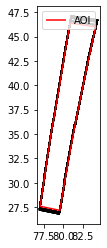

In [29]:
fig, ax = plt.subplots()

for index, row in df_pairs_dict.iterrows():
    p = gpd.GeoSeries(row['geometry'])
    p.exterior.plot(color='black', ax=ax)
df_aoi.exterior.plot(color='red', ax=ax, label='AOI')
plt.legend()

# Deduplication Pt. 1

A `GUNW` is uniquely determined by the reference and secondary IDs. We contanenate these sorted lists and generate a lossy hash to deduplicate products we may have introduced from the enumeration above.

In [30]:
import hashlib
import json


def get_gunw_hash_id(reference_ids: list, secondary_ids: list) -> str:
    all_ids = json.dumps([' '.join(sorted(reference_ids)),
                          ' '.join(sorted(secondary_ids))
                          ]).encode('utf8')
    hash_id = hashlib.md5(all_ids).hexdigest()
    return hash_id

def hasher(row):
    return get_gunw_hash_id(row['reference'], row['secondary'])

In [31]:
df_pairs['hash_id'] = df_pairs.apply(hasher, axis=1)
f"# of duplicated entries: {df_pairs.duplicated(subset=['hash_id']).sum()}"

'# of duplicated entries: 0'

In [32]:
df_pairs = df_pairs.drop_duplicates(subset=['hash_id']).reset_index(drop=True)
f"# of UNIQUE GUNWs: {df_pairs.shape[0]}"

'# of UNIQUE GUNWs: 1690'

# Viewing GUNW pairs

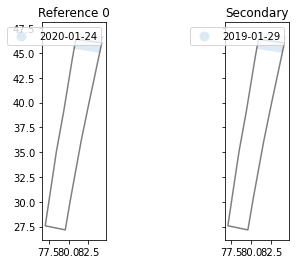

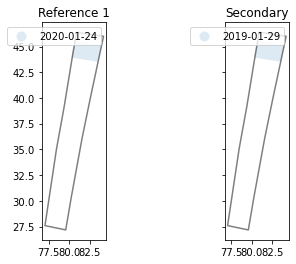

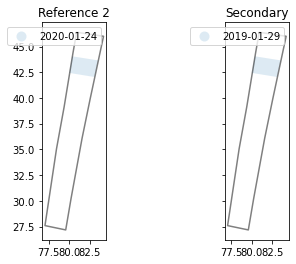

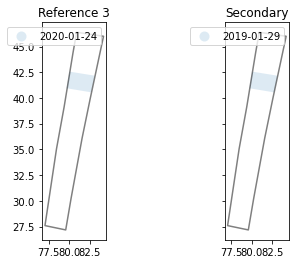

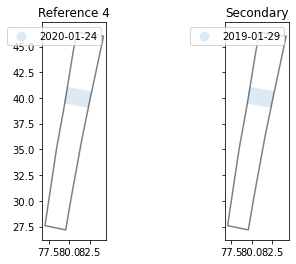

In [33]:
# start index
M = 0
# number of pairs to view
N = 5

for J in range(M, M + N):
    pair = ifg_pairs[J]

    fig, axs = plt.subplots(1, 2, sharey=True, sharex=True)

    df_ref_plot = pair['reference']
    df_sec_plot = pair['secondary']

    df_ref_plot.plot(column='start_date_str', 
                     legend=True, 
                     ax=axs[0], alpha=.15)
    df_aoi.exterior.plot(ax=axs[0], alpha=.5, color='black')
    axs[0].set_title('Reference')

    df_sec_plot.plot(column='start_date_str', 
                     legend=True, 
                     ax=axs[1], alpha=.15)
    df_aoi.exterior.plot(ax=axs[1], alpha=.5, color='black')
    
    axs[0].set_title(f'Reference {J}')
    axs[1].set_title('Secondary')

# Update types for Graphical Analysis

We want to do some basic visualization to support the understanding if we traverse time correctly. We do some simple standard pandas manipulation.

In [34]:
df_pairs['reference_date'] = pd.to_datetime(df_pairs['reference_date'])
df_pairs['secondary_date'] = pd.to_datetime(df_pairs['secondary_date'])
df_pairs.head()

,reference,secondary,reference_date,secondary_date,path_number,geometry,startTime,stopTime,fileID,ind_col,hash_id
0,[S1A_IW_SLC__1SDV_20200124T003907_20200124T003...,[S1A_IW_SLC__1SDV_20190129T003900_20190129T003...,2020-01-24,2019-01-29,63,"POLYGON ((83.91435 45.00756, 83.91435 45.00756...",2019-01-29 00:39:00,2019-01-29 00:39:28,S1A_IW_SLC__1SDV_20200124T003907_20200124T0039...,0,5223acf01ee1d4dd273b526ba3d37db8
1,[S1A_IW_SLC__1SDV_20200124T003933_20200124T004...,[S1A_IW_SLC__1SDV_20190129T003926_20190129T003...,2020-01-24,2019-01-29,63,"POLYGON ((82.31485 45.33666, 83.90346 45.14144...",2019-01-29 00:39:26,2019-01-29 00:39:53,S1A_IW_SLC__1SDV_20200124T003933_20200124T0040...,1,236ece2bb642be7f4a041279ff66d2a1
2,[S1A_IW_SLC__1SDV_20200124T003957_20200124T004...,[S1A_IW_SLC__1SDV_20190129T003951_20190129T004...,2020-01-24,2019-01-29,63,"POLYGON ((80.36161 44.04758, 80.36161 44.04758...",2019-01-29 00:39:51,2019-01-29 00:40:18,S1A_IW_SLC__1SDV_20200124T003957_20200124T0040...,2,42d7d6b9372166186c48f52dceb8878e
3,[S1A_IW_SLC__1SDV_20200124T004022_20200124T004...,[S1A_IW_SLC__1SDV_20190129T004016_20190129T004...,2020-01-24,2019-01-29,63,"POLYGON ((82.36105 42.25912, 83.08797 42.16506...",2019-01-29 00:40:16,2019-01-29 00:40:43,S1A_IW_SLC__1SDV_20200124T004022_20200124T0040...,3,e48213111bed796bd20309cd9d6d9ca5
4,[S1A_IW_SLC__1SDV_20200124T004047_20200124T004...,[S1A_IW_SLC__1SDV_20190129T004041_20190129T004...,2020-01-24,2019-01-29,63,"POLYGON ((82.73958 40.66926, 82.73958 40.66926...",2019-01-29 00:40:41,2019-01-29 00:41:08,S1A_IW_SLC__1SDV_20200124T004047_20200124T0041...,4,a324d5884212810fe6c21dee037f949c


# Visualize a Date Graph from Time Series

We can put this into a network Directed Graph and use some simple network functions to check connectivity.

We are going to use just dates for nodes, though you could use `(ref_date, hash_id)` for nodes and then inspect connected components. That is for another notebook.

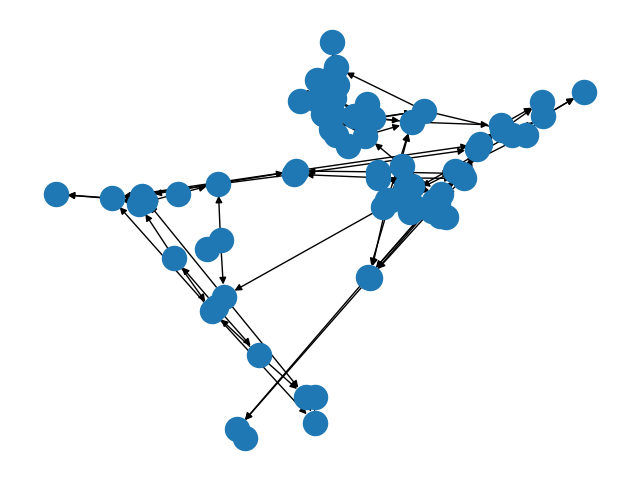

In [35]:
# Get unique dates
unique_dates = df_pairs.reference_date.tolist() + df_pairs.secondary_date.tolist()
unique_dates = sorted(list(set(unique_dates)))

# initiate and plot date notes
date2node = {date: k for (k, date) in enumerate(unique_dates)}
node2date = {k: date for (date, k) in date2node.items()}

%matplotlib widget
G = nx.DiGraph()

edges = [(date2node[ref_date], date2node[sec_date]) 
         for (ref_date, sec_date) in zip(df_pairs.reference_date, df_pairs.secondary_date)]
G.add_edges_from(edges)
nx.draw(G)

This function checks there is a path from the first date to the last one. The y-axis is created purely for display so doesn't really indicated anything but flow by month.

In [36]:
nx.has_path(G, 
            target=date2node[unique_dates[0]],
            source=date2node[unique_dates[-1]])

False

Ensure that the result above returns a ```True``` value to be able to produce a time-series.

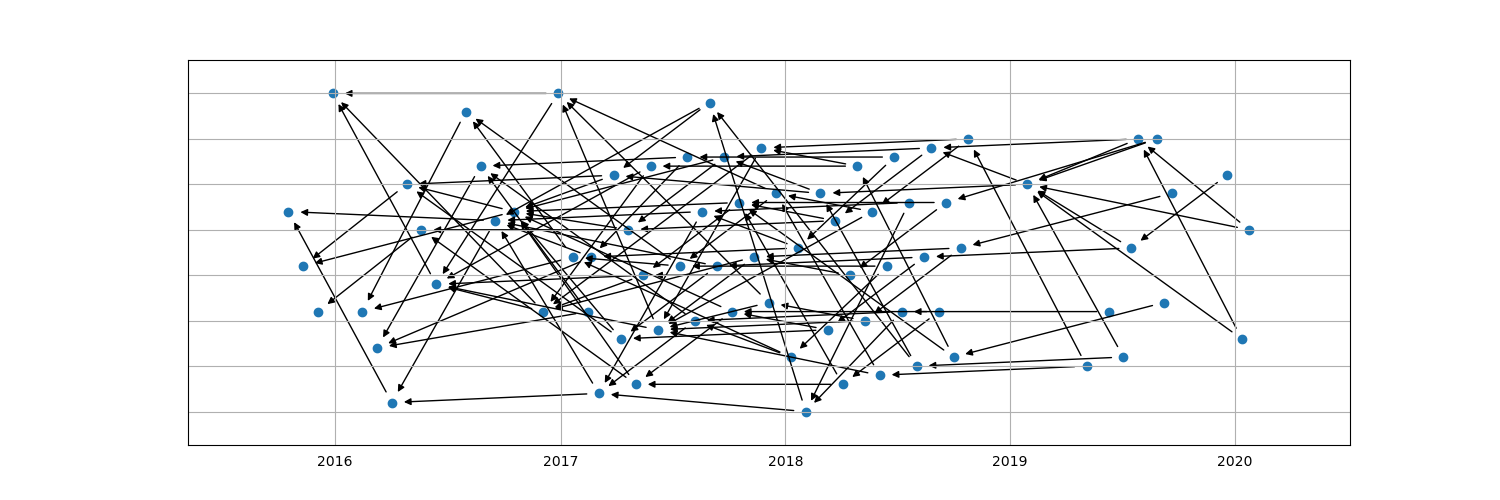

In [37]:
fig, ax = plt.subplots(figsize=(15, 5))

increment = [date.month + date.day for date in unique_dates]

# source: https://stackoverflow.com/a/27852570
scat = ax.scatter(unique_dates, increment)
position = scat.get_offsets().data

pos = {date2node[date]: position[k] for (k, date) in enumerate(unique_dates)}
nx.draw_networkx_edges(G, pos=pos, ax=ax)
ax.grid('on')
ax.tick_params(axis='x',
               which='major',
               labelbottom=True,
               labelleft=True)
ymin, ymax = ax.get_ylim()